## Análisis de resultados.
En esta hoja de notas queremos comparar los resultados extraidos del DR3 de los obtenidos en el DR2 en el trabajo 
[Baumgardt et al., 2019](https://drive.google.com/file/d/1VtDW8WacV4sDh1wr_FGPmesjclg6zdbZ/view)

## Requirements

In [1]:
%load_ext autoreload
%autoreload 2


#@markdown ### Librerías y funciones auxiliares
import sys
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astroquery.vizier import Vizier
from dotenv import load_dotenv
from tqdm import tqdm

# Añadir el directorio raíz del proyecto al sys.path
project_path = os.path.abspath(os.path.join(os.getcwd(), "../src"))  # Subir un nivel
if project_path not in sys.path:
    sys.path.append(project_path)
            

from hyper_velocity_stars_detection.jobs.utils import read_catalog_file
from hyper_velocity_stars_detection.jobs.google_jobs.utils import load_project, ProjectDontExist

load_dotenv("../data/.env")
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../data/hvs-storage.json"
PATH = "../data/globular_clusters"
SELECTED_CLUSTERS = read_catalog_file(os.path.join(PATH, "mwgc.dat.txt"))

/home/santhiperbolico/Documentos/UCM/tfm-ucm-code/src/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Resultados Previos
Resultados en el DR2 en el trabajo [Baumgardt et al., 2019](https://drive.google.com/file/d/1VtDW8WacV4sDh1wr_FGPmesjclg6zdbZ/view)

In [2]:
v = Vizier(columns=["Name", "Rsun", "e_Rsun", "pmRA*", "e_pmRA*", "pmDE", "e_pmDE", "RV", "e_RV", "rho"])
v.ROW_LIMIT = -1
catalogs = v.get_catalogs("J/MNRAS/482/5138")
clusters_dr2 = catalogs[0].to_pandas()
clusters_dr2.Name = clusters_dr2.Name.str.lower()

clusters_dr2["parallax"] = 1 / (clusters_dr2.Rsun)
clusters_dr2["e_parallax"] = (1 / (clusters_dr2.Rsun - clusters_dr2.e_Rsun) - 1 / (clusters_dr2.Rsun + clusters_dr2.e_Rsun)) / 2
clusters_dr2 = clusters_dr2[["Name","parallax", "e_parallax", "pmRA_", "e_pmRA_", "pmDE", "e_pmDE", "RV", "e_RV", "rho", "Rsun", "e_Rsun"]]
clusters_dr2

,Name,parallax,e_parallax,pmRA_,e_pmRA_,pmDE,e_pmDE,RV,e_RV,rho,Rsun,e_Rsun
0,ngc 104,0.225734,0.002038,5.25,0.01,-2.53,0.01,-17.209999,0.18,0.04,4.430000,0.04
1,ngc 288,0.100200,0.003317,4.22,0.01,-5.65,0.01,-44.830002,0.13,0.31,9.980000,0.33
2,ngc 362,0.109051,0.003094,6.71,0.01,-2.51,0.01,223.259995,0.28,-0.09,9.170000,0.26
3,whiting 1,0.031949,NaN,-0.04,0.12,-1.78,0.08,-130.410004,1.79,-0.09,31.299999,NaN
4,ngc 1261,0.064558,NaN,1.61,0.02,-2.05,0.02,71.360001,0.24,0.19,15.490000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
149,ngc 7089,0.095147,0.003354,3.51,0.01,-2.16,0.01,-3.720000,0.34,0.01,10.510000,0.37
150,ngc 7099,0.125000,0.008952,-0.73,0.01,-7.24,0.01,-185.190002,0.17,0.53,8.000000,0.57
151,pal 12,0.052632,NaN,-3.28,0.03,-3.31,0.03,27.910000,0.28,0.33,19.000000,NaN
152,pal 13,0.040323,NaN,1.64,0.09,0.25,0.07,25.870001,0.27,0.04,24.799999,NaN


Extraemos la información de la relación masa luminosidad de los cluster del trabajo [McLaughlin & van der Marel, 2005](https://vizier.cds.unistra.fr/viz-bin/VizieR-3?-source=J/ApJS/161/304/table13&-out.max=50&-out.form=HTML%20Table&-out.add=_r&-out.add=_RAJ,_DEJ&-sort=_r&-oc.form=sexa)

In [3]:
catalog2= "J/ApJS/161/304/table13"
catalog1 = "J/ApJS/161/304/clusters"
catalog2= "J/ApJS/161/304/models"

v = Vizier(columns=["**"])
v.ROW_LIMIT = -1
catalogs = v.get_catalogs([catalog1, catalog2])
clusters_ml = catalogs[0].to_pandas()
tbl_2 = catalogs[1].to_pandas()

properties = ["Ltot", "Mtot", "M_L"]
for prop in properties:
    df_p = tbl_2[["Cluster", prop, f"e_{prop}", f"E_{prop}"]].sort_values(["Cluster", f"e_{prop}", f"E_{prop}"])
    clusters_ml = pd.merge(clusters_ml, df_p.groupby("Cluster").first().reset_index(), on="Cluster")

clusters_ml.SName = clusters_ml.SName.str.lower()
clusters_ml

,recno,Cluster,RAJ2000,DEJ2000,SB,M,D,SName,logAge,__Fe_H_,...,e__M_L_6,Ltot,e_Ltot,E_Ltot,Mtot,e_Mtot,E_Mtot,M_L,e_M_L,E_M_L
0,1,FORNAX1,02 37 02.1,-34 11 00,SB,M,,name fornax 1,10.11,-2.20,...,0.147,4.12,0.03,0.03,4.40,0.05,0.05,1.915,0.163,0.163
1,2,FORNAX2,02 38 40.1,-34 48 05,SB,M,,name fornax 2,10.11,-1.78,...,0.145,4.80,0.04,0.04,5.07,0.05,0.05,1.867,0.156,0.156
2,3,FORNAX3,02 39 52.5,-34 16 08,SB,M,D,name fornax 3,10.11,-1.96,...,0.145,5.13,0.04,0.04,5.40,0.05,0.05,1.880,0.159,0.159
3,4,FORNAX4,02 40 07.9,-34 32 19,SB,M,D,name fornax 4,10.06,-1.90,...,0.076,4.94,0.05,0.05,5.18,0.05,0.05,1.717,0.075,0.075
4,5,FORNAX5,02 42 21.1,-34 06 05,SB,M,D,name fornax 5,10.11,-2.20,...,0.147,4.82,0.04,0.04,5.10,0.05,0.05,1.915,0.163,0.163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,212,SMC-NGC339,00 57 48.9,-74 28 00,SB,M,,ngc 339,9.80,-1.50,...,0.117,4.87,0.05,0.06,4.90,0.07,0.07,1.088,0.104,0.104
149,213,SMC-NGC361,01 02 12.8,-71 36 16,SB,M,,ngc 361,9.91,-1.45,...,0.109,5.18,0.08,0.09,5.30,0.08,0.10,1.313,0.101,0.101
150,214,SMC-NGC411,01 07 56.0,-71 46 05,SB,M,,ngc 411,9.15,-0.68,...,0.038,4.86,0.05,0.05,4.47,0.10,0.10,0.410,0.080,0.080
151,215,SMC-NGC416,01 07 59.0,-72 21 20,SB,M,,ngc 416,9.84,-1.44,...,0.102,5.14,0.04,0.04,5.21,0.05,0.05,1.181,0.084,0.084


In [4]:
df_clusters = pd.merge(clusters_dr2, clusters_ml, left_on=["Name"], right_on="SName", how="left")
df_clusters

,Name,parallax,e_parallax,pmRA_,e_pmRA_,pmDE,e_pmDE,RV,e_RV,rho,...,e__M_L_6,Ltot,e_Ltot,E_Ltot,Mtot,e_Mtot,E_Mtot,M_L,e_M_L,E_M_L
0,ngc 104,0.225734,0.002038,5.25,0.01,-2.53,0.01,-17.209999,0.18,0.04,...,0.224,5.68,0.01,0.01,6.05,0.04,0.04,2.348,0.239,0.239
1,ngc 288,0.100200,0.003317,4.22,0.01,-5.65,0.01,-44.830002,0.13,0.31,...,0.186,4.56,0.01,0.01,4.85,0.04,0.04,1.972,0.165,0.165
2,ngc 362,0.109051,0.003094,6.71,0.01,-2.51,0.01,223.259995,0.28,-0.09,...,0.190,5.23,0.01,0.01,5.53,0.04,0.04,2.013,0.171,0.171
3,whiting 1,0.031949,NaN,-0.04,0.12,-1.78,0.08,-130.410004,1.79,-0.09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ngc 1261,0.064558,NaN,1.61,0.02,-2.05,0.02,71.360001,0.24,0.19,...,0.180,4.94,0.00,0.00,5.20,0.04,0.04,1.928,0.158,0.158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,ngc 7089,0.095147,0.003354,3.51,0.01,-2.16,0.01,-3.720000,0.34,0.01,...,0.157,5.57,0.01,0.01,5.84,0.04,0.04,1.872,0.154,0.154
150,ngc 7099,0.125000,0.008952,-0.73,0.01,-7.24,0.01,-185.190002,0.17,0.53,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
151,pal 12,0.052632,NaN,-3.28,0.03,-3.31,0.03,27.910000,0.28,0.33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
152,pal 13,0.040323,NaN,1.64,0.09,0.25,0.07,25.870001,0.27,0.04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Resultados DR3

In [7]:
CLUSTER_NAME = "ngc 5139"

cluster = [cl for cl in SELECTED_CLUSTERS if cl.name == CLUSTER_NAME][0]
project = load_project(cluster_name=cluster.name, project_id = os.getenv("PROJECT_ID"), bucket_name=os.getenv("BUCKET"),path=PATH)
print(str(project))

Las muestras analizadas de ngc 5139 son:
Muestras seleccionadas del objeto astronómico ngc 5139 con radio 1:
	 - df_1_c0 - Todas las estrellas seleccionadas: 78454.
	 - df_1_c1 - Las estrellas con errores de paralaje y pm menores al 10%: 15391.
	 - df_1_c2 - Las estrellas con un error de paralaje menor del 30% y de pm menores al 10%: 16148.
	 - df_1_c3 - Las estrellas con un error de paralaje menor del 10% y de pm menores al 20%.: 16479.

Muestras seleccionadas del objeto astronómico ngc 5139 con radio 6:
	 - df_6_c0 - Todas las estrellas seleccionadas: 48251.
	 - df_6_c1 - Las estrellas con errores de paralaje y pm menores al 10%: 1970.
	 - df_6_c2 - Las estrellas con un error de paralaje menor del 30% y de pm menores al 10%: 2258.
	 - df_6_c3 - Las estrellas con un error de paralaje menor del 10% y de pm menores al 20%.: 2226.

Se han encontrado 10 fuentes de rayos X.
Estimated number of clusters: 9
Estimated number of noise points: 9212
	 - Volumen total del cluster 0: 6149.
	 - Vol

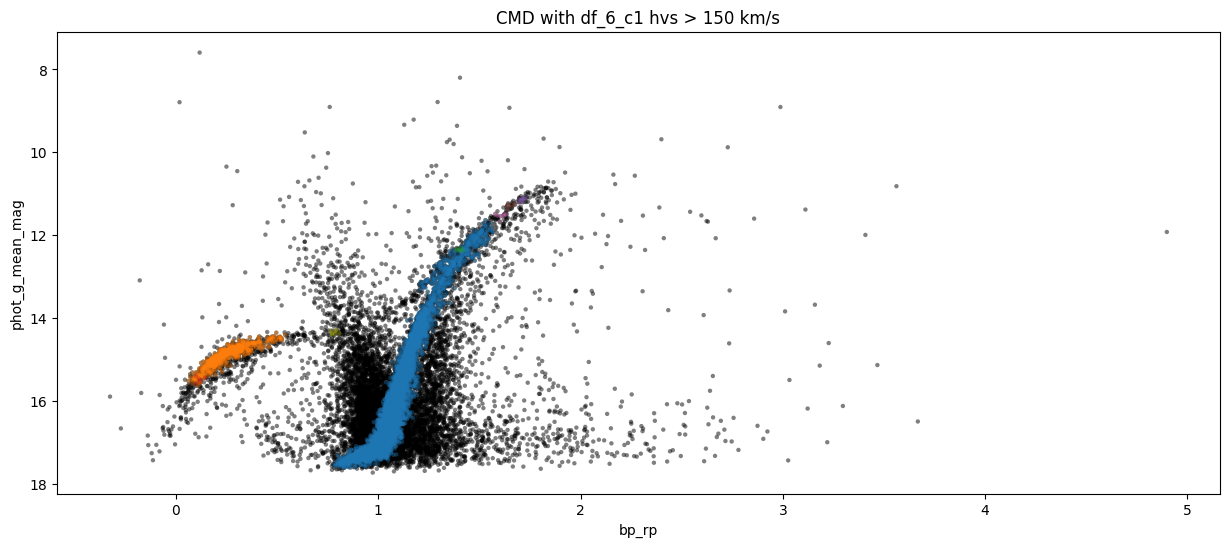

In [8]:
fig, ax = project.plot_cmd(
            hvs_candidates_name="df_6_c1",
            factor_sigma = 1.0,
            hvs_pm = 150,
            legend=False
)

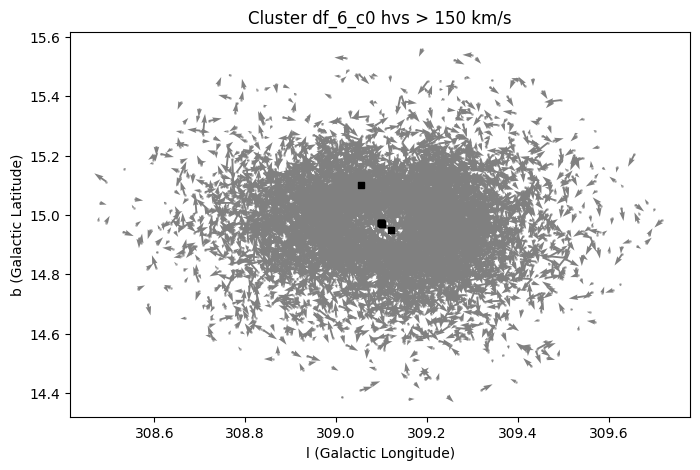

In [9]:
fig, ax = project.plot_cluster(
            hvs_candidates_name="df_6_c0",
            factor_sigma = 1,
            hvs_pm = 150,
            legend=False,
            factor_size=5
)

In [11]:
project.xsource.results

,mission,main_id,obsid,name,ra,dec,lii,bii,time,exposure,public_date,class,SEARCH_OFFSET_
0,xmmmaster,NGC_5139,310990101,Omega Centauri,201.72795,-47.49525,309.12113,14.94975,53599.884907,0.0,53599.0,GLOBULAR CLUSTER EXTENDED GALACTIC OR EXTRAGAL...,"1.571 (201.6970129813,-47.4794725273)\n"
1,xmmmaster,NGC_5139,212090401,Omega Centauri,201.69165,-47.47694,309.09868,14.97135,53377.781887,0.0,53377.0,GLOBULAR CLUSTER EXTENDED GALACTIC OR EXTRAGAL...,"0.265 (201.6970129813,-47.4794725273)\n"
2,xmmmaster,NaN,117730401,PSR0540,201.65835,-47.46122,309.07791,14.99009,51591.994074,0.0,51611.0,SNR,"1.913 (201.6970129813,-47.4794725273)\n"
3,xmmmaster,NGC_5139,412780101,Omega Centauri,201.60210,-47.35525,309.05430,15.10036,53968.375949,0.0,53968.0,UNIDENTIFIED,"8.391 (201.6970129813,-47.4794725273)\n"
4,xmmmaster,NGC_5139,112220101,Omega Cen,201.69165,-47.47583,309.09884,14.97245,52133.982454,37463.0,52539.0,GLOBULAR CLUSTER EXTENDED GALACTIC OR EXTRAGAL...,"0.308 (201.6970129813,-47.4794725273)\n"
5,xmmmaster,NGC_5139,117740101,Omega Cent,201.69165,-47.47694,309.09868,14.97135,51590.590567,-4.0,52539.0,GLOBULAR CLUSTER EXTENDED GALACTIC OR EXTRAGAL...,"0.265 (201.6970129813,-47.4794725273)\n"
6,chanmaster,NGC_5139,13726,NGC 5139,201.69458,-47.47908,309.10039,14.96895,56034.344942,175970.0,56404.0,X-RAY BINARY,"0.101 (201.6970129813,-47.4794725273)\n"
7,chanmaster,NGC_5139,13727,NGC 5139,201.69458,-47.47908,309.10039,14.96895,56033.262917,49150.0,56404.0,X-RAY BINARY,"0.101 (201.6970129813,-47.4794725273)\n"
8,chanmaster,NGC_5139,1519,NGC 5139,201.69125,-47.47694,309.09840,14.97139,51568.189306,44150.0,51956.0,CV,"0.279 (201.6970129813,-47.4794725273)\n"
9,chanmaster,NGC_5139,653,NGC 5139,201.69125,-47.47694,309.09840,14.97139,51567.093032,25350.0,51956.0,CV,"0.279 (201.6970129813,-47.4794725273)\n"


In [79]:
np.sqrt(((project.xsource.results[["ra", "dec"]] - pd.Series({"ra": project.astro_object.coord.ra.value, "dec": project.astro_object.coord.dec.value}))**2).sum(1))


0    0.000477
1    0.000477
dtype: float64

In [82]:
df_hvs_candidates = project.get_data("df_6_c1")
selected = project.clustering_results.selected_hvs(df_hvs_candidates, 1, 150)
selected["pm_kms"] - project.clustering_results.gc.pm_kms.mean()

44      3912.616757
189      185.249398
240    20992.546106
249    13916.524833
Name: pm_kms, dtype: float64

In [37]:
gc = project.clustering_results.gc
display(gc[["pmra", "pmdec", "parallax", "radial_velocity"]].describe())

,pmra,pmdec,parallax,radial_velocity
count,3178.000000,3178.000000,3178.000000,14.000000
mean,6.689348,-2.541506,0.098350,222.774982
std,0.274240,0.238239,0.165665,6.183480
min,5.613027,-3.347277,-0.333036,209.430340
25%,6.527407,-2.692505,-0.009814,220.485917
50%,6.689895,-2.544841,0.088572,225.028985
75%,6.850607,-2.388271,0.198966,226.207500
max,7.848253,-1.667750,0.632380,233.334140


In [114]:
df_results = pd.DataFrame(columns=["Name", "parallax" , "e_parallax", "pmRA_", "e_pmRA_", "pmDE", "e_pmDE", "RV", "e_RV"])
selected_clusters = [cl.name for cl in SELECTED_CLUSTERS]
drs_clusters_name = clusters_dr2.Name.unique()
index = 0

project_dont_exist = []

other_error = []

for cluster_name in tqdm(drs_clusters_name, desc="Procesando clusters", unit="item", total=drs_clusters_name.size):
    gc = None
    if cluster_name in selected_clusters:
        project = None
        try:
            project = load_project(cluster_name=cluster_name, project_id = os.getenv("PROJECT_ID"), bucket_name=os.getenv("BUCKET"),path=PATH)
        except ProjectDontExist:
            project_dont_exist.append(cluster_name)
        if project is not None:
            try:
                gc = project.clustering_results.gc
            except Exception as error:
                other_error.append({"cluster_name": cluster_name, "error": error})

    if isinstance(gc, pd.DataFrame):
        df_results.loc[index] = (
            cluster_name,
            gc.parallax.mean(),
            gc.parallax.std(),
            gc.pmra.mean(),
            gc.pmra.std(),
            gc.pmdec.mean(),
            gc.pmdec.std(),
            gc.radial_velocity.mean(),
            gc.radial_velocity.std(),
        )
        index+=1

#df_results.to_csv("../data/results_dr3.csv")

df_results

Procesando clusters: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 154/154 [05:22<00:00,  2.10s/item]


,Name,parallax,e_parallax,pmRA_,e_pmRA_,pmDE,e_pmDE,RV,e_RV
0,ngc 104,0.195411,0.077816,5.251557,0.374576,-2.574233,0.384599,-17.202012,10.794205
1,ngc 288,0.091271,0.233088,4.146267,0.282245,-5.698109,0.318848,-44.344806,4.199802
2,ngc 362,0.098350,0.165665,6.689348,0.274240,-2.541506,0.238239,222.774982,6.183480
3,ngc 1261,0.036289,0.033148,1.583140,0.081924,-2.088191,0.091288,NaN,NaN
4,pal 2,-0.089661,0.046878,1.207839,0.052625,-1.610529,0.113121,NaN,NaN
...,...,...,...,...,...,...,...,...,...
111,ngc 7078,0.081798,0.138198,-0.668563,0.205976,-3.819091,0.205440,-97.948590,7.954244
112,ngc 7089,0.041305,0.142201,3.459262,0.267278,-2.162357,0.192856,-4.291132,9.054682
113,ngc 7099,0.107517,0.189351,-0.743859,0.258501,-7.287414,0.209380,-178.786405,19.652915
114,pal 12,0.027138,0.295531,-3.128356,0.659657,-3.479046,0.395203,NaN,NaN


In [5]:
df_results = pd.read_csv("../data/results_dr3.csv", index_col=0)
df_results = pd.merge(df_results, df_clusters, on="Name", suffixes=["", "_dr2"])
df_results

,Name,parallax,e_parallax,pmRA_,e_pmRA_,pmDE,e_pmDE,RV,e_RV,parallax_dr2,...,e__M_L_6,Ltot,e_Ltot,E_Ltot,Mtot,e_Mtot,E_Mtot,M_L,e_M_L,E_M_L
0,ngc 104,0.195411,0.077816,5.251557,0.374576,-2.574233,0.384599,-17.202012,10.794205,0.225734,...,0.224,5.68,0.01,0.01,6.05,0.04,0.04,2.348,0.239,0.239
1,ngc 288,0.091271,0.233088,4.146267,0.282245,-5.698109,0.318848,-44.344806,4.199802,0.100200,...,0.186,4.56,0.01,0.01,4.85,0.04,0.04,1.972,0.165,0.165
2,ngc 362,0.098350,0.165665,6.689348,0.274240,-2.541506,0.238239,222.774982,6.183480,0.109051,...,0.190,5.23,0.01,0.01,5.53,0.04,0.04,2.013,0.171,0.171
3,ngc 1261,0.036289,0.033148,1.583140,0.081924,-2.088191,0.091288,NaN,NaN,0.064558,...,0.180,4.94,0.00,0.00,5.20,0.04,0.04,1.928,0.158,0.158
4,pal 2,-0.089661,0.046878,1.207839,0.052625,-1.610529,0.113121,NaN,NaN,0.036765,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,ngc 7078,0.081798,0.138198,-0.668563,0.205976,-3.819091,0.205440,-97.948590,7.954244,0.097847,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
112,ngc 7089,0.041305,0.142201,3.459262,0.267278,-2.162357,0.192856,-4.291132,9.054682,0.095147,...,0.157,5.57,0.01,0.01,5.84,0.04,0.04,1.872,0.154,0.154
113,ngc 7099,0.107517,0.189351,-0.743859,0.258501,-7.287414,0.209380,-178.786405,19.652915,0.125000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114,pal 12,0.027138,0.295531,-3.128356,0.659657,-3.479046,0.395203,NaN,NaN,0.052632,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
mask_p = (df_results.parallax_dr2 >= df_results.parallax - df_results.e_parallax) & (df_results.parallax_dr2 <= df_results.parallax + df_results.e_parallax)
mask_pmra = (df_results.pmRA__dr2 >= df_results.pmRA_ - df_results.e_pmRA_) & (df_results.pmRA__dr2 <= df_results.pmRA_ + df_results.e_pmRA_)
mask_pmde = (df_results.pmDE_dr2 >= df_results.pmDE - df_results.e_pmDE) & (df_results.pmDE_dr2 <= df_results.pmDE + df_results.e_pmDE)

mask_ml = ~df_results.M_L.isna()
df_results[mask_p & mask_pmra & mask_pmde & mask_ml]

,Name,parallax,e_parallax,pmRA_,e_pmRA_,pmDE,e_pmDE,RV,e_RV,parallax_dr2,...,e__M_L_6,Ltot,e_Ltot,E_Ltot,Mtot,e_Mtot,E_Mtot,M_L,e_M_L,E_M_L
0,ngc 104,0.195411,0.077816,5.251557,0.374576,-2.574233,0.384599,-17.202012,10.794205,0.225734,...,0.224,5.68,0.01,0.01,6.05,0.04,0.04,2.348,0.239,0.239
1,ngc 288,0.091271,0.233088,4.146267,0.282245,-5.698109,0.318848,-44.344806,4.199802,0.100200,...,0.186,4.56,0.01,0.01,4.85,0.04,0.04,1.972,0.165,0.165
2,ngc 362,0.098350,0.165665,6.689348,0.274240,-2.541506,0.238239,222.774982,6.183480,0.109051,...,0.190,5.23,0.01,0.01,5.53,0.04,0.04,2.013,0.171,0.171
3,ngc 1261,0.036289,0.033148,1.583140,0.081924,-2.088191,0.091288,NaN,NaN,0.064558,...,0.180,4.94,0.00,0.00,5.20,0.04,0.04,1.928,0.158,0.158
5,ngc 1851,0.061133,0.202520,2.139701,0.290165,-0.635930,0.350788,321.920143,8.442055,0.088261,...,0.187,5.20,0.00,0.00,5.49,0.04,0.04,1.981,0.166,0.166
6,ngc 1904,0.064324,0.019521,2.468129,0.072044,-1.603807,0.084122,NaN,NaN,0.075358,...,0.163,4.92,0.01,0.01,5.20,0.04,0.04,1.877,0.154,0.154
7,ngc 2298,0.108575,0.178001,3.305322,0.204225,-2.161879,0.228651,NaN,NaN,0.092593,...,0.144,4.22,0.02,0.02,4.49,0.04,0.04,1.870,0.157,0.157
8,ngc 2419,0.034822,0.045432,0.014955,0.054755,-0.566950,0.046044,NaN,NaN,0.012022,...,0.146,5.67,0.01,0.01,5.95,0.04,0.04,1.903,0.161,0.161
9,ngc 2808,0.077545,0.125226,0.990114,0.247000,0.273112,0.224392,99.535877,22.053969,0.097943,...,0.191,5.62,0.03,0.03,5.93,0.05,0.05,2.018,0.172,0.172
12,ngc 3201,0.193116,0.173014,8.339855,0.257906,-1.965549,0.245846,496.112096,9.627532,0.221729,...,0.162,4.77,0.03,0.03,5.04,0.05,0.05,1.876,0.154,0.154
